# Librerías

In [1]:
import pandas as pd
import numpy as np

# Para hacer resumen del df
from summarytools import dfSummary

# Estadísticas
from statistics import median
from scipy.stats import zscore
from pyod.models.mad import MAD
from scipy.stats import median_abs_deviation
from scipy.spatial import distance # Para distancia de Mahalanobis
from scipy.stats.mstats import winsorize

# scikit-learn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Para graficar
import matplotlib.pyplot as plt
import seaborn as sns

# 1. A partir del dataset ruidoso.txt realice los siguientes análisis:

## a. Cargue y explore el dataset explicando en qué consiste y las características que posee el mismo.

In [181]:
ruidoso = pd.read_csv("data/ruidoso.txt")

Se usa la función **read_csv** de pandas para leer la información contenida en el archivo ruidoso.txt, y se guarda esta en un objeto llamado **ruidoso**.

In [182]:
dfSummary(ruidoso, is_collapsible=False)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Unnamed: 0[int64],Mean (sd) : 33.5 (19.2)min < med < max:1.0 < 33.5 < 66.0IQR (CV) : 32.5 (1.7),66 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACR0lEQVR4nO3Zu47aUBhF4f9wk7nIFkKBjmbKSClc8hB52DxCCp6AIk0qOiSEjPCMhTFOk6Qc8HEcz5bXV3PYFlozCNuVZWnAR9dr+wKAZwwevcA5Nzazkef7X8uyfPM828ntmrttb/fM7O559t3rfjdU59x4sVh8DcNw7rN8Pp9PzrlvPh9cF7fr7ra5XRTFME3Tl9ls9rPX6+VVzz+67kf/UUdhGM43m81bFEVZleEkSYLtdjs/Ho8jM/P5C+/itvdu29v7/X6+2+0+xXH8Y7Vanaqcfea6H371m5lFUZQtl8vXKuO/jT3OdH67xm5r26fTaWxmNp1OG/nM+DEFCYQKCYQKCYQKCYQKCYQKCU/dnvJVFMXQzELnnM/x8H6/Dzu2XWu37e0mNRZqmqbDPM+/rNfrfr/fr3wDOc/zoCiKz1mWfTezSvflVLfr7La93bTGQr1er4MgCCZxHGdVn1SY/X3SMbndbv2ubNfZbXu7aY1+9Zv5P6n486SjS9v/Yrft7abwYwoSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSBs+8KEmSoOobXy6XwMwsTdPgcDhM/ud51W3V6657/pm+fgFCZ6mynxud/gAAAABJRU5ErkJggg=="">",0(0.0%)
2,Road_55dB[int64],Mean (sd) : 159228.8 (484751.3)min < med < max:7600.0 < 37550.0 < 3108200.0IQR (CV) : 59950.0 (0.3),61 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB40lEQVR4nO3XsU7CUBSH8XNEsUTpDUUZeQBMfAB2HX1YV3dWBl+CpZFWY4kNuW4uJmIvGvzH7zf33HuTfm1TjzEa8NcdHfoAwHcc77rA3Qdm1k9c/y3G2CTOAh++DNXdB+Px+C7P81HK4nVdP7n7PbFiX7veqP08z0fz+bwJIWy6LFxVVbZYLEZlWfbNjFCxl52ffjOzEMJmMpm8Jqw/SJgBPuFnChIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRKOD32Ar7j7wMz6ieNvMcbmJ8+Dw/nVULfb7YmZ5e6eMp4VRXEbQjhLGa7r+snd7/9brId8uH9z72+FWlVV1nXX1Wo1bNv2ejqd9nq93qbrfNu2mZldzWazx+Fw+Nxltmma0+VyeVmW5YW71133FpYVRXETQjhPGV6v1y/u/mBmne/XvnvverG8A+3sY8cpONmSAAAAAElFTkSuQmCC"">",0(0.0%)
3,Road_60dB[int64],Mean (sd) : 78587.9 (251409.0)min < med < max:4000.0 < 17400.0 < 1469100.0IQR (CV) : 24425.0 (0.3),63 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB80lEQVR4nO3XQW7aQBiG4f8vqYNVmJFxw5IDUIkDcIAuc9gcgi0SvQSbUWRXqmlc5O66aQXxpGn6Se+z5huP5FcgfBgGA/537976AsBz3Fz7gLuXZlZknv80DEOXuQV+uRiqu5d1Xd+HEKqcw9u2fXT3B2LFS137Ri1CCNV2u+1ijKcxBzdNM93tdlVKqTAzQsWLXP3pNzOLMZ6Wy+W3jPPLjA3wG/5MQQKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQsLNW1/gEncvzazInD8Nw9D9zfvgstd8X68a6vl8fm9mwd1z5tPFYvE5xvghZ9y27aO7PxDrv+HuZV3X9yGEKmd/7X09K9SmaaZjH3w8Hud9329Wq9VkMpmcxu77vp+a2af1ev1lPp9/HbPtuu52v9/fpZQ+uns79tnIEmaz2d1ms/lRluX3McOu624Ph0OVUirM7I+h/gS4/GS7jFUA0wAAAABJRU5ErkJggg=="">",0(0.0%)
4,Railways_65dB[int64],Mean (sd) : 1139.4 (4778.8)min < med < max:0.0 < 100.0 < 29700.0IQR (CV) : 400.0 (0.2),18 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABpUlEQVR4nO3XQWrbUBSG0feMa2wwErbBG+guPM+0i80ivIsuwQQJXIcEVZ11ElLHMjT54ZypdK/e4ENCdRzHAl/d7LMPAB8xv3ZDrXVVSllM3P8yjuNl4iz89c9Qa62r3W73o2mazZTlfd8/1Vofxcq9rr1RF03TbA6Hw6Vt2+dbFnddtzwej5vT6bQopQiVu1z99JdSStu2z/v9/teE/asJM/CGnykiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiS

A continuación se crea una función de usuario para verificar si una lista de valores son todos consecutivos y distintos entre sí.

In [183]:
def son_diferentes_consecutivos(lista):
    for i in range(len(lista) - 1):
        if lista[i] == lista[i + 1]:
            return False
        if lista[i] + 1 != lista[i + 1]:
            return False
    return True

# Verificar si los valores son diferentes y consecutivos
variable = "Unnamed: 0"
if son_diferentes_consecutivos(ruidoso[variable]):
    print(f"Los valores de la variable {variable} son diferentes y consecutivos.")
else:
    print(f"Los valores de la variable {variable} no son diferentes y consecutivos.")

Los valores de la variable Unnamed: 0 son diferentes y consecutivos.


Las variables en este archivo parecen representar diferentes tipos de ruido (presumiblemente en diferentes áreas o ubicaciones), y los valores numéricos parecen ser mediciones de niveles de ruido en decibelios (dB) en diferentes condiciones ambientales.

Una descripción tentativa de las variables podría ser:

- Road_55dB: Esta variable parece representar mediciones de ruido provenientes de carreteras con un nivel de 55 decibelios (dB).

- Road_60dB: Esta variable parece representar mediciones de ruido provenientes de carreteras con un nivel de 60 decibelios (dB).

- Railways_65dB: Esta variable parece representar mediciones de ruido provenientes de ferrocarriles con un nivel de 65 decibelios (dB).

- Industry_65dB: Esta variable parece representar mediciones de ruido provenientes de industrias con un nivel de 65 decibelios (dB).

Con la ayuda de la función **dfSummary**, se obtiene un resumen del dataframe **ruidoso**. se puede observar que este dataframe tiene una dimensión de 66 filas y 5 columnas, no tiene duplicados y las 5 variables son numéricas, sin embargo, la primera variable **Unnamed: 0** contiene 66 valores distintos que va desde 1 hasta 66 (verificado con la función de usuario), por lo que en realidad esta variable es un índice del dataframe y no una variable como tal. Por último, se puede observar que la variable **Industry_65dB** tiene un valor faltante, y dicho valor faltante está afectando la salida de los estadísticos de resumen tales como la media y la mediana de esta variable, por lo tanto, se usará otra función para conocer los estadísticos de resumen de esta.

In [184]:
ruidoso.set_index('Unnamed: 0', drop=True, inplace=True)
ruidoso.index.name = None 
ruidoso

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
1,166400,79200,1100,0.0
2,20000,11000,0,0.0
3,37800,18000,0,0.0
4,24500,16700,0,100.0
5,103100,33500,1900,200.0
...,...,...,...,...
62,20700,16200,0,0.0
63,15100,9900,0,0.0
64,24500,12400,300,300.0
65,12800,8500,0,0.0


Del anterior código, la variable **Unnamed: 0** se transformó en índece.

In [185]:
ruidoso.describe()

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
count,6.600000e+01,6.600000e+01,66.000000,65.000000
mean,1.592288e+05,7.858788e+04,1139.393939,180.000000
std,4.847513e+05,2.514090e+05,4778.827625,537.993959
min,7.600000e+03,4.000000e+03,0.000000,0.000000
25%,1.895000e+04,1.007500e+04,0.000000,0.000000
50%,3.755000e+04,1.740000e+04,100.000000,0.000000
75%,7.890000e+04,3.450000e+04,400.000000,100.000000
max,3.108200e+06,1.469100e+06,29700.000000,4000.000000


Usando la función **describe** se obtiene los estadísticos de resumen para la variable **Industry_65dB** que no se pudo obtener usando la función **dfSummary** debido el valor faltante. De esta forma, se puede observar que la media de estas 4 variables numéricas es mayor a la mediana, por lo que se espera que la distribución de cada una de estas variables sea sesgada hacia la derecha como visto en los histogramas de la función **dfSummary**. También, se puede observar que la variabilidad presente en cada una de estas variables es relativamente alta. Por lo último, también se tiene el mínimo, los percentiles, y el máximo de cada una de las variables.

## b. Realice un breve análisis exploratorio para identificar la distribución de las variables usadas en la base de datos ¿será que existe relación entre las variables?

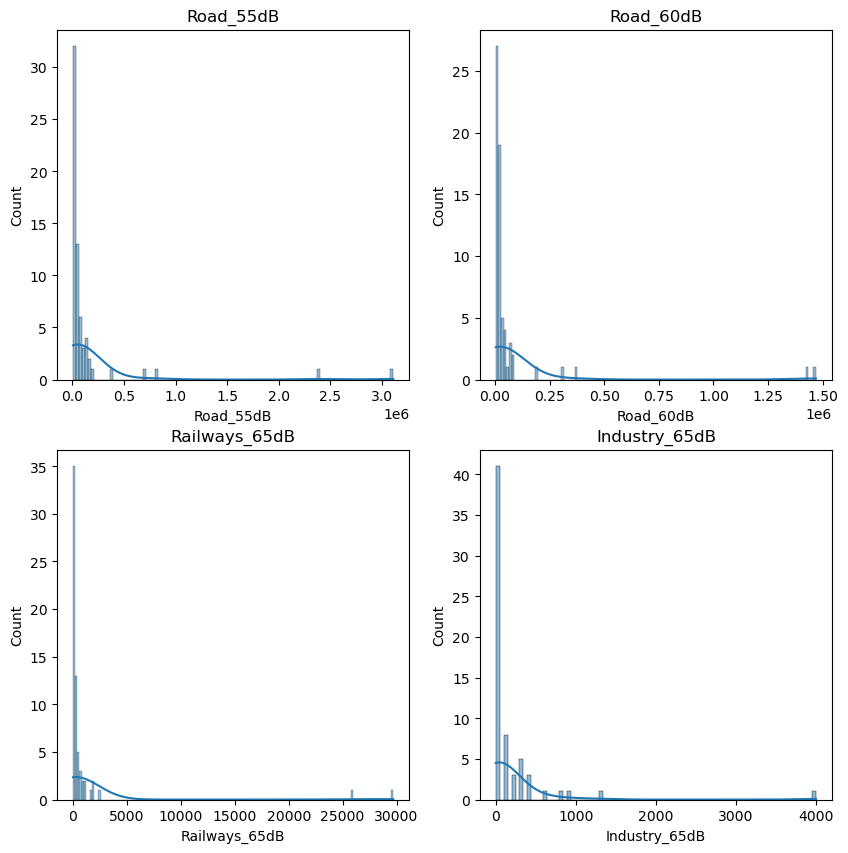

In [186]:
# Crear una figura y ejes utilizando subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Crear gráficos de distribución para cada variable en la cuadrícula de ejes
sns.histplot(ruidoso['Road_55dB'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Road_55dB')

sns.histplot(ruidoso['Road_60dB'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Road_60dB')

sns.histplot(ruidoso['Railways_65dB'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Railways_65dB')

sns.histplot(ruidoso['Industry_65dB'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Industry_65dB')

plt.show()

De las anteriores gráficas, se puede observar que la distribución de cada una de las variables tienen formas muy parecidas, especialmente entre las variables **Road_55dB** y **Road_60dB**. Por lo tanto, se puede creer que estas variables tengan algún tipo de relación, para esto, se usará gráficas de dispersión y medidas de correlación.

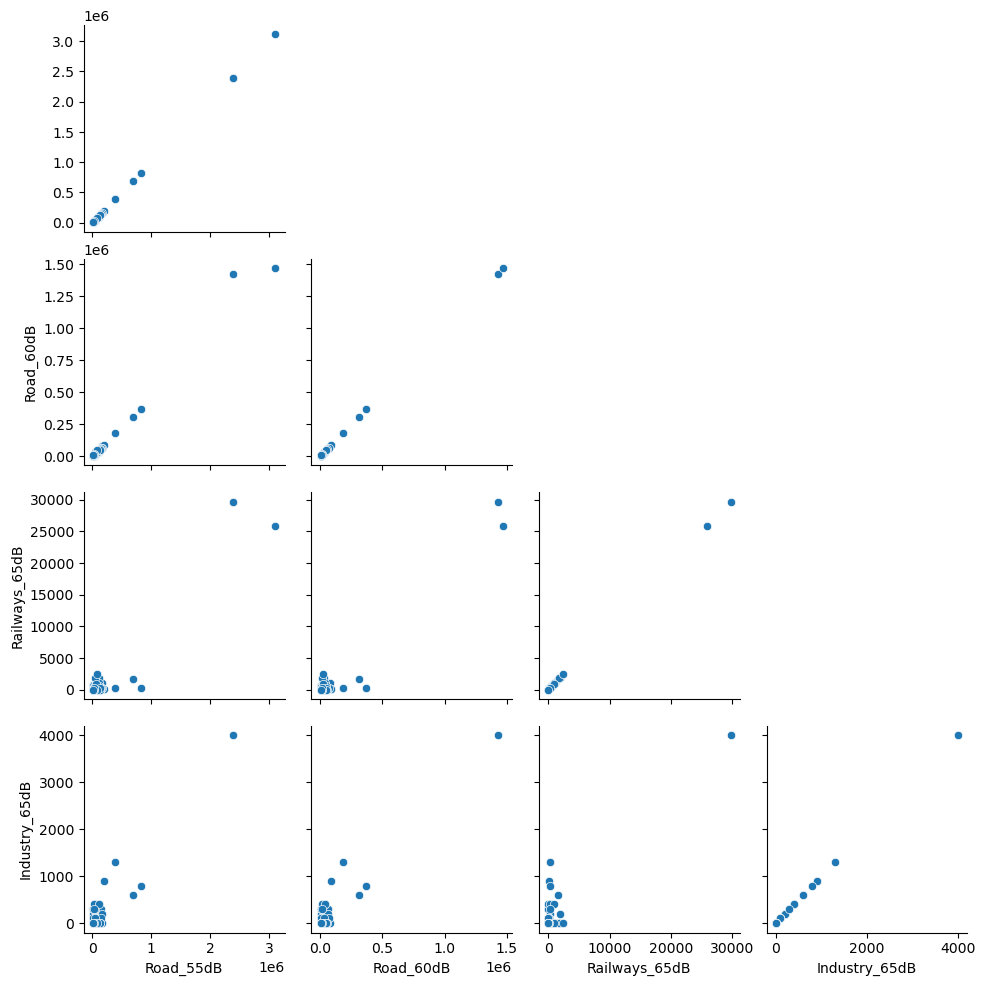

In [187]:
sns.pairplot(ruidoso,
             corner=1,
             diag_kind=None)
plt.show()

Del anterior código se creó gráficos de dispersión por pares con la ayuda de la función **pairplot** de **seaborn**. Aquí, se puede ver claramente que las variables **Road_60dB** y **Road_55dB** tienen una relación lineal, mientras que las otras combinaciones de las variables no tienen una relación lineal. Por último, se puede observar que existen valores atípicos a nivel bivariado.

<AxesSubplot:>

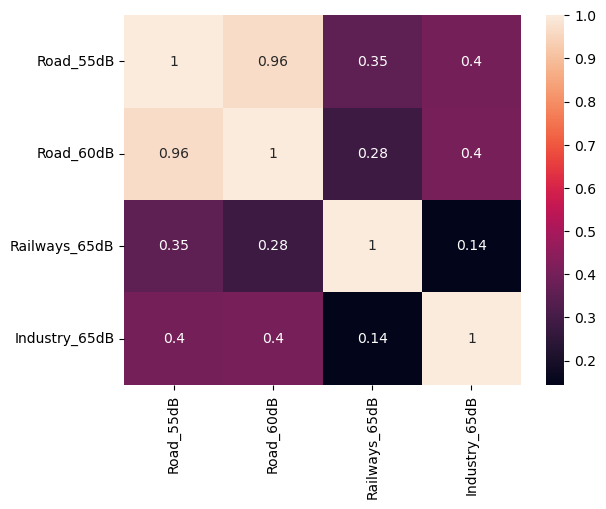

In [188]:
sns.heatmap(ruidoso.corr(method="spearman"), annot=True)

Teniendo en cuenta el anterior análisis, se empleó la medida de correlación de spearman para cuantificar la correlación existente entre las variables. Se puede observar que las variables con más correlación son **Road_60dB** y **Road_55dB** con un valor de 0.96, mientras que la correlación en las otras variables no superan 0.4, es decir, tienen una correlación relativamente débil.

## c. Verifique si existen problemas de datos atípicos en cada una de las variables usando las metodologías de detección a nivel univariado.

### Boxplots

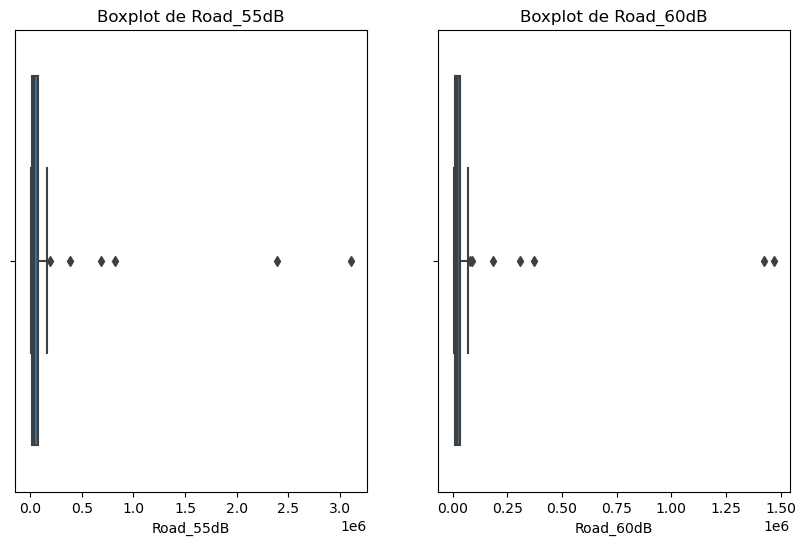

In [189]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,6))

axes[0].set_title("Boxplot de Road_55dB")
axes[1].set_title("Boxplot de Road_60dB")

sns.boxplot(ax=axes[0], data = ruidoso, x = "Road_55dB")
sns.boxplot(ax=axes[1], data = ruidoso, x = "Road_60dB")

plt.show()

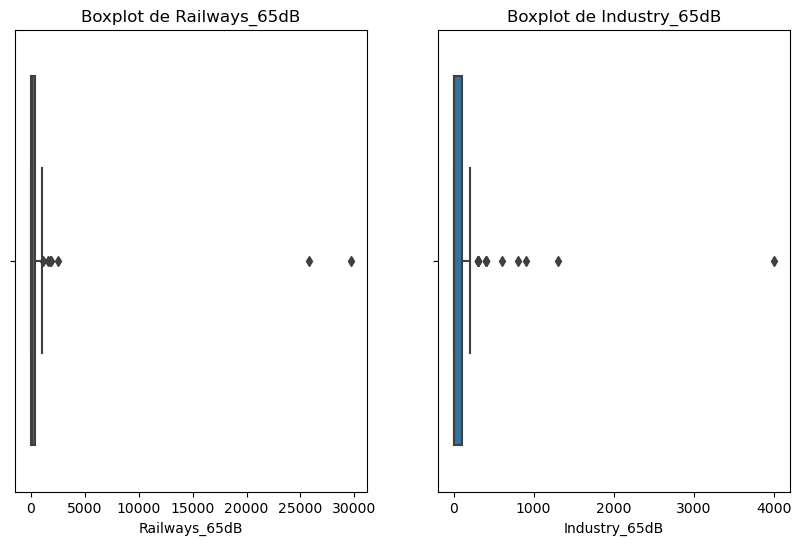

In [190]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,6))

axes[0].set_title("Boxplot de Railways_65dB")
axes[1].set_title("Boxplot de Industry_65dB")

sns.boxplot(ax=axes[0], data = ruidoso, x = "Railways_65dB")
sns.boxplot(ax=axes[1], data = ruidoso, x = "Industry_65dB")

plt.show()

Usando los boxplots se puede observar que existen datos atípicos a nivel univariado en cada una de las variables.

### z-score

In [191]:
# Calculate z-score for each data point and compute its absolute value
z_scores = zscore(ruidoso['Road_55dB'], nan_policy="omit")
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = ruidoso[abs_z_scores > 3]
outliers.Road_55dB

49    2387200
66    3108200
Name: Road_55dB, dtype: int64

In [192]:
# Calculate z-score for each data point and compute its absolute value
z_scores = zscore(ruidoso['Road_60dB'], nan_policy="omit")
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = ruidoso[abs_z_scores > 3]
outliers.Road_60dB

49    1426100
66    1469100
Name: Road_60dB, dtype: int64

In [193]:
# Calculate z-score for each data point and compute its absolute value
z_scores = zscore(ruidoso['Railways_65dB'], nan_policy="omit")
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = ruidoso[abs_z_scores > 3]
outliers.Railways_65dB

49    29700
66    25800
Name: Railways_65dB, dtype: int64

In [194]:
# Calculate z-score for each data point and compute its absolute value
z_scores = zscore(ruidoso['Industry_65dB'], nan_policy="omit")
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = ruidoso[abs_z_scores > 3]
outliers.Industry_65dB

49    4000.0
Name: Industry_65dB, dtype: float64

Empleando el método de zscore con un umbral de 3 a cada una de las variables, se puede observar que según este criterio solo hay 2 valores atípicos (observación 49 y 66) por variable exceptuando la variable **Industry_65dB** que solo tiene un valor atípico (observación 49). Sin embargo, no se puede confiar en los resultados de este criterio, ya que las distribuciones vistas anteriormente no son simétricas y no se distribuyen normal.

### z-score modificado

Este método pretende calcular la siguiente cantidad:

$$
M_i =  \frac{{0.6745*(x_i-Mediana)}}{{MAD}}
$$

Hay que tener en cuenta que la cantidad MAD no puede ser nulo.

In [195]:
# Set threshold to 3.5
mad = MAD(threshold = 3.5)

# Convert the 'total' column into a 2D numpy array
Road_55dB_reshaped = ruidoso['Road_55dB'].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(Road_55dB_reshaped).labels_

# Obtain number of outliers
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 7


In [196]:
outliers = ruidoso[labels == 1]
outliers.Road_55dB

1      166400
8      388000
13     192900
15     823200
29     689300
49    2387200
66    3108200
Name: Road_55dB, dtype: int64

Usando el método de z-score modificado se ha encontrado 7 valores atípicos para la variable **Road_55dB**. Este criterio es más confiable que el z-score, ya que la distribución de esta variable es asimétrica.

In [197]:
# Convert the 'total' column into a 2D numpy array
Road_60dB_reshaped = ruidoso['Road_60dB'].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(Road_60dB_reshaped).labels_

# Obtain number of outliers
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 10


In [198]:
outliers = ruidoso[labels == 1]
outliers.Road_60dB

1       79200
8      185200
13      86000
15     371700
18      66200
27      67300
29     309300
45      69700
49    1426100
66    1469100
Name: Road_60dB, dtype: int64

Usando el método de z-score modificado se ha encontrado 10 valores atípicos para la variable **Road_60dB**. Este criterio es más confiable que el z-score, ya que la distribución de esta variable es asimétrica.

In [199]:
# Convert the 'total' column into a 2D numpy array
Railways_65dB_reshaped = ruidoso['Railways_65dB'].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(Railways_65dB_reshaped).labels_

# Obtain number of outliers
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 11


In [200]:
outliers = ruidoso[labels == 1]
outliers.Railways_65dB

1      1100
5      1900
11      700
29     1600
30      800
32     1000
41     1800
49    29700
50     2500
56      900
66    25800
Name: Railways_65dB, dtype: int64

Usando el método de z-score modificado se ha encontrado 11 valores atípicos para la variable **Railways_65dB**. Este criterio es más confiable que el z-score, ya que la distribución de esta variable es asimétrica.

In [201]:
# Eliminar filas con valores NaN en la columna 'Industry_65dB'
ruidoso_cleaned = ruidoso.dropna(subset=['Industry_65dB'])

# Convertir la columna 'Industry_65dB' a un arreglo numpy 2D
Industry_65dB_cleaned = ruidoso_cleaned['Industry_65dB'].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(Industry_65dB_cleaned).labels_

# Obtain number of outliers
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 24


c:\Users\David\anaconda3\lib\site-packages\pyod\models\mad.py:129: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num(np.ravel(0.6745 * diff / self.median_diff_))
c:\Users\David\anaconda3\lib\site-packages\pyod\models\mad.py:129: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.ravel(0.6745 * diff / self.median_diff_))
c:\Users\David\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [202]:
outliers = ruidoso_cleaned[labels == 1]
outliers.Industry_65dB

4      100.0
5      200.0
6      100.0
7      300.0
8     1300.0
9      200.0
10     100.0
12     100.0
13     900.0
15     800.0
18     300.0
19     300.0
20     300.0
21     400.0
26     400.0
27     200.0
29     600.0
32     400.0
38     100.0
45     100.0
49    4000.0
54     100.0
58     100.0
64     300.0
Name: Industry_65dB, dtype: float64

In [203]:
# Obtain the MAD value
mad_score = median_abs_deviation(ruidoso_cleaned['Industry_65dB']) # Industry_65dB
mad_score

0.0

Usando el método de z-score modificado se ha encontrado 24 valores atípicos para la variable **Industry_65dB**. Este criterio presenta problemas ya que el MAD tiene el valor de 0, por lo tanto no se puede confiar en los resultados de la anterior salida.

### Rango intercuartil (IQR)

Primeramente, se crea una función de usuario **atipico_intercuartil** que permite encontrar los datos atípicos usando el método intercuartil, la función imprime un mensaje de cuántos datos atípicos halló bajo este método y retorna los datos atípicos de la respectiva variable.

In [250]:
def atipico_intercuartil(data, variable):
    '''
    Descripción: función de usuario que permite hallar datos atípicos usando el método de rango intercuartil (IQR).

    data: dataframe de pandas.
    variable: variable a utilizar para hallar los datos atípicos. String

    retorna: outliers[variable]
    '''
    # Calculate the percentiles
    seventy_fifth = data[variable].quantile(0.75)
    twenty_fifth = data[variable].quantile(0.25)

    # Obtain IQR
    iqr = seventy_fifth - twenty_fifth

    # Upper and lower thresholds
    upper = seventy_fifth + (1.5 * iqr)
    lower = twenty_fifth - (1.5 * iqr)

    # Subset the dataset
    outliers = data[(data[variable] < lower) | (data[variable] > upper)]
    print(f"Se detectan {len(outliers[variable])} valores atípicos en la variable {variable} usando el método intercuartil")
    return outliers[variable]

In [205]:
atipico_intercuartil(ruidoso, "Road_55dB")

Se detectan 6 valores atípicos en la variable Road_55dB usando el método intercuartil


8      388000
13     192900
15     823200
29     689300
49    2387200
66    3108200
Name: Road_55dB, dtype: int64

In [206]:
atipico_intercuartil(ruidoso, "Road_60dB")

Se detectan 7 valores atípicos en la variable Road_60dB usando el método intercuartil


1       79200
8      185200
13      86000
15     371700
29     309300
49    1426100
66    1469100
Name: Road_60dB, dtype: int64

In [207]:
atipico_intercuartil(ruidoso, "Railways_65dB")

Se detectan 7 valores atípicos en la variable Railways_65dB usando el método intercuartil


1      1100
5      1900
29     1600
41     1800
49    29700
50     2500
66    25800
Name: Railways_65dB, dtype: int64

In [208]:
atipico_intercuartil(ruidoso, "Industry_65dB")

Se detectan 13 valores atípicos en la variable Industry_65dB usando el método intercuartil


7      300.0
8     1300.0
13     900.0
15     800.0
18     300.0
19     300.0
20     300.0
21     400.0
26     400.0
29     600.0
32     400.0
49    4000.0
64     300.0
Name: Industry_65dB, dtype: float64

En conclusión, este método puede ser el más adecuado para la detección de los datos atípicos a nivel univariado para los datos usados en este ejercicio, ya que este método no requiere que los datos se distribuyan como una normal y no presenta problemas numéricos como el método de z-score modificado para la variable **Industry_65db**.

## d. ¿Se detectan valores atípicos a nivel multivariado?

Teniendo en cuenta que existe un valor faltante y esto afecta el cálculo de la distancia de Mahalanobis, se procede a imputar el valor faltante por la mediana de la respectiva variable.

In [209]:
ruidoso_sin_faltante = ruidoso.fillna(median(ruidoso.Industry_65dB))
ruidoso_sin_faltante.tail()

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
62,20700,16200,0,0.0
63,15100,9900,0,0.0
64,24500,12400,300,300.0
65,12800,8500,0,0.0
66,3108200,1469100,25800,0.0


### Distancia de Mahalanobis

In [210]:
# Calculamos la matriz de covarianza de las variables
cov_matrix = np.cov(ruidoso_sin_faltante, rowvar=False)

# Calculamos la inversa de la matriz de covarianza
cov_inv = np.linalg.inv(cov_matrix)

# Calculamos la distancia de Mahalanobis para cada fila en el DataFrame
dist_mahalanobis = []
for row in ruidoso_sin_faltante.values:
    dist = distance.mahalanobis(row, ruidoso_sin_faltante.mean(), cov_inv)
    dist_mahalanobis.append(dist)

# Agregamos la distancia de Mahalanobis como una nueva columna en el DataFrame
ruidoso_sin_faltante['mahalanobis_distance'] = dist_mahalanobis

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance
1,166400,79200,1100,0.0,0.700726
2,20000,11000,0,0.0,0.724467
3,37800,18000,0,0.0,0.700625
4,24500,16700,0,100.0,0.641624
5,103100,33500,1900,200.0,3.196330
...,...,...,...,...,...
62,20700,16200,0,0.0,1.150109
63,15100,9900,0,0.0,0.800643
64,24500,12400,300,300.0,1.109024
65,12800,8500,0,0.0,0.764907


In [225]:
# Ordenamos el DataFrame por la columna de distancia de Mahalanobis en orden descendente
df_sorted = ruidoso_sin_faltante.sort_values(by='mahalanobis_distance', ascending=False)

# Seleccionamos aquellos registros con las distancias mayor a 2
distancia_mayor_a_dos = df_sorted[df_sorted.mahalanobis_distance >= 2]
distancia_mayor_a_dos

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance,lof_score
49,2387200,1426100,29700,4000.0,7.930110,13.401267
66,3108200,1469100,25800,0.0,7.772388,15.602701
15,823200,371700,300,800.0,5.383971,10.668763
8,388000,185200,300,1300.0,4.321800,7.136681
13,192900,86000,100,900.0,3.368562,1.549033
29,689300,309300,1600,600.0,3.313313,9.165655
50,77200,24300,2500,0.0,3.207822,0.951998
5,103100,33500,1900,200.0,3.196330,1.240279
32,102800,41600,1000,400.0,2.290744,1.180531
41,47500,17400,1800,0.0,2.081142,1.127663


In [239]:
len(distancia_mayor_a_dos)

11

Usando la distancia de Mahalanobis y usando un criterio personal (distancia mayor o igual a 2), se han encontrado 11 valores atípicos a nivel multivariado.

### Local Outlier Factor

Para este método de búsqueda de datos atípicos, se usará los 5 vecinos más cercanos y no la configuración predeterminada.

In [221]:
# Calculamos el LOF para las tres variables
lof = LocalOutlierFactor(n_neighbors = 5)
lof.fit_predict(ruidoso_sin_faltante)

# Obtenemos los scores LOF para cada punto
scores_lof = -lof.negative_outlier_factor_

# Agregamos los scores LOF como una nueva columna en el DataFrame
ruidoso_sin_faltante['lof_score'] = scores_lof

# Mostramos el DataFrame con los scores LOF
ruidoso_sin_faltante

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance,lof_score
1,166400,79200,1100,0.0,0.700726,1.184494
2,20000,11000,0,0.0,0.724467,1.101867
3,37800,18000,0,0.0,0.700625,0.986031
4,24500,16700,0,100.0,0.641624,0.979519
5,103100,33500,1900,200.0,3.196330,1.240279
...,...,...,...,...,...,...
62,20700,16200,0,0.0,1.150109,1.159004
63,15100,9900,0,0.0,0.800643,0.975804
64,24500,12400,300,300.0,1.109024,0.994866
65,12800,8500,0,0.0,0.764907,1.011528


In [224]:
# Ordenamos el DataFrame por la columna 'lof_score' en orden descendente
df_sorted = ruidoso_sin_faltante.sort_values(by='lof_score', ascending=False)

# Seleccionamos los primeros diez registros con los scores LOF más grandes
primeros_diez_lof = df_sorted.head(10)
primeros_diez_lof

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance,lof_score
66,3108200,1469100,25800,0.0,7.772388,15.602701
49,2387200,1426100,29700,4000.0,7.930110,13.401267
15,823200,371700,300,800.0,5.383971,10.668763
29,689300,309300,1600,600.0,3.313313,9.165655
8,388000,185200,300,1300.0,4.321800,7.136681
30,7600,4000,800,0.0,0.974601,1.698795
13,192900,86000,100,900.0,3.368562,1.549033
25,17700,5800,0,0.0,0.450939,1.506205
24,8600,5800,100,0.0,0.651516,1.472590
38,31600,10700,200,100.0,0.566397,1.464228


In [228]:
distancia_mayor_a_dos.index

Int64Index([49, 66, 15, 8, 13, 29, 50, 5, 32, 41, 61], dtype='int64')

Del anterior dataframe ordenado de mayor a menor mediante el criterio lof_score, se puede observar que los primeros 5 registros tiene un lof_scores relativamente altos, por lo tanto estas observaciones se pueden considerar como potenciales atípicos a nivel multivariado. Cabe destarcar, que estos 5 registros también se consideran como atípicos usando el método de distancia de Mahalanobis.

### Isolation Forest

In [237]:
# Definimos la cantidad de árboles
n_arboles = 300

# Inicializamos y ajustamos el modelo Isolation Forest con la cantidad de árboles especificada
isolation_forest = IsolationForest(n_estimators=n_arboles, random_state=42)
puntajes_anomalia = isolation_forest.fit(ruidoso_sin_faltante)

# Obtenemos los puntajes de anomalía para cada muestra
puntajes_anomalia = isolation_forest.score_samples(ruidoso_sin_faltante)

# Convertimos los puntajes de anomalía a valores positivos
puntajes_anomalia = -puntajes_anomalia

# Obtenemos las etiquetas de anomalía (inlier/outlier) para cada punto
#etiquetas_anomalia = isolation_forest.predict(df_selected)

# Agregamos las etiquetas de anomalía como una nueva columna en el DataFrame
ruidoso_sin_faltante['puntajes_anomalia'] = puntajes_anomalia

# Ordenamos el DataFrame por los puntajes de anomalía en orden descendente
df_sorted = ruidoso_sin_faltante.sort_values(by='puntajes_anomalia', ascending=False)

# Seleccionamos los primeros diez registros con los puntajes de anomalía más altos
puntaje_mayor_a_un_medio = df_sorted[df_sorted.puntajes_anomalia > 0.5]
puntaje_mayor_a_un_medio

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance,lof_score,puntajes_anomalia
49,2387200,1426100,29700,4000.0,7.930110,13.401267,0.798670
66,3108200,1469100,25800,0.0,7.772388,15.602701,0.792813
15,823200,371700,300,800.0,5.383971,10.668763,0.684241
8,388000,185200,300,1300.0,4.321800,7.136681,0.675898
29,689300,309300,1600,600.0,3.313313,9.165655,0.665750
13,192900,86000,100,900.0,3.368562,1.549033,0.616185
50,77200,24300,2500,0.0,3.207822,0.951998,0.564258
5,103100,33500,1900,200.0,3.196330,1.240279,0.532627
1,166400,79200,1100,0.0,0.700726,1.184494,0.530318
32,102800,41600,1000,400.0,2.290744,1.180531,0.513076


In [238]:
len(puntaje_mayor_a_un_medio)

12

Usando el método de isolation forest con 300 árboles y un criterio personal (puntajes_anomalia > 0.5), se ha detectado 12 datos atípicos. Cabe destacar que los primeros 5 datos atípicos hallados coinciden con los hallados en los primeros dos métodos de detección de datos atípicos a nivel multivariado. Por lo tanto, se puede concluir que los datos con índices 49, 66, 15, 8 y 29 son potenciales atípicos a nivel multivariado.

## e. Para el caso univariado, escoja una variable y realice un análisis sobre las implicaciones que tiene realizar diferentes tratamientos a los datos atípicos en la distribución de la respectiva variable.

Para este ejercicio se elige la variable **Railways_65dB**. Nuevamente, se halla la distribución de dicha variable.

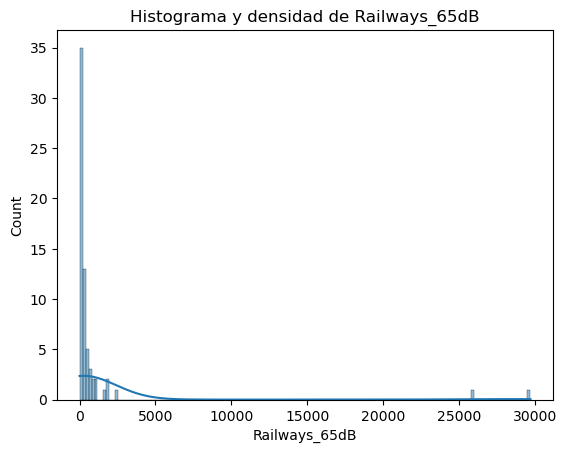

In [244]:
sns.histplot(ruidoso['Railways_65dB'], kde=True)
plt.title("Histograma y densidad de Railways_65dB")
plt.show()

### Eliminación

Para eliminar datos atípicos hay que estar seguro de que los outliers provengan de un error en la entrada de los datos, como un error humano o de medida, y no se pueda solucionar. Aquí, no hay seguridad sobre esto, sin embargo, se procede a eliminarlos para ver cuál es el efecto que tiene sobre la distribución original de los datos. El criterio de datos atípicos a usar será el de rango intercuartil.

In [261]:
indices_excluir = atipico_intercuartil(ruidoso, "Railways_65dB").index

Se detectan 7 valores atípicos en la variable Railways_65dB usando el método intercuartil


In [264]:
ruidoso_filtrado = ruidoso.drop(indices_excluir)
ruidoso_filtrado.reset_index(drop = True, inplace=True)

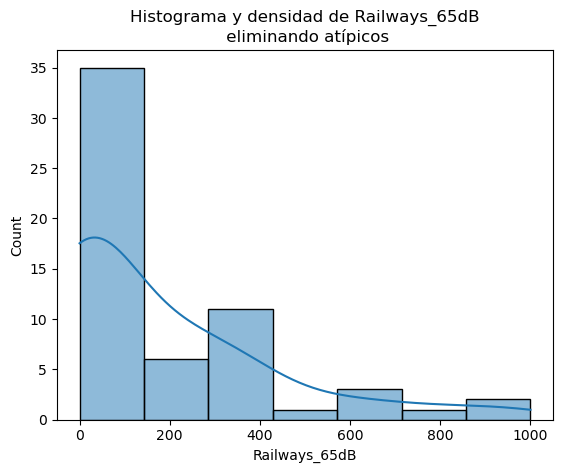

In [269]:
sns.histplot(ruidoso_filtrado['Railways_65dB'], kde=True)
plt.title("Histograma y densidad de Railways_65dB\n eliminando atípicos")
plt.show()

Luego de la eliminación de estos atípicos, se puede observar que este proceso tuvo un impacto enorme en la distribución de los datos, la nueva distribución cuenta con una cola menos pesada.

### Imputación

En este método, los datos atípicos hallados por el método de rango inteercuartil serán reemplazados por la mediana de la variable.

In [270]:
# Reemplazar los valores correspondientes a los índices dados por la mediana
ruidoso_modificado = ruidoso.copy()
ruidoso_modificado.loc[indices_excluir, 'Railways_65dB'] = median(ruidoso.Railways_65dB)

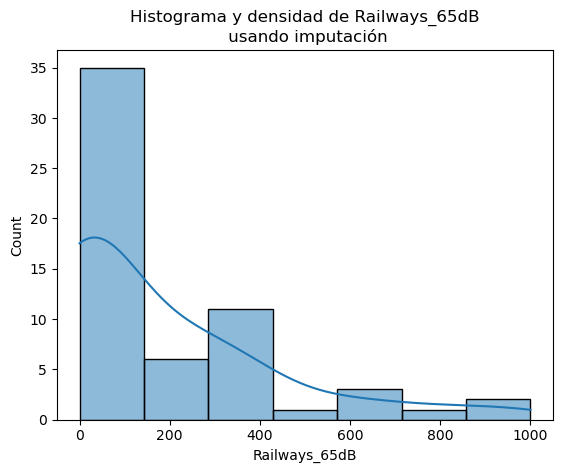

In [271]:
sns.histplot(ruidoso_filtrado['Railways_65dB'], kde=True)
plt.title("Histograma y densidad de Railways_65dB\n usando imputación")
plt.show()

Se puede observar que la imputación tuvo un efecto parecido al del anterior método.

### Winsorización

En este paso, se utiliza el método de winsorización para reemplezar el 10% de los valores más altos (7 datos aproximadamente) por los valores del percentil 90 de la distribución.

In [278]:
ruidoso_winsorized = ruidoso.copy()
ruidoso_winsorized['Railways_65dB'] = winsorize(ruidoso_winsorized['Railways_65dB'],\
  limits = [0, 0.1], inplace = True)

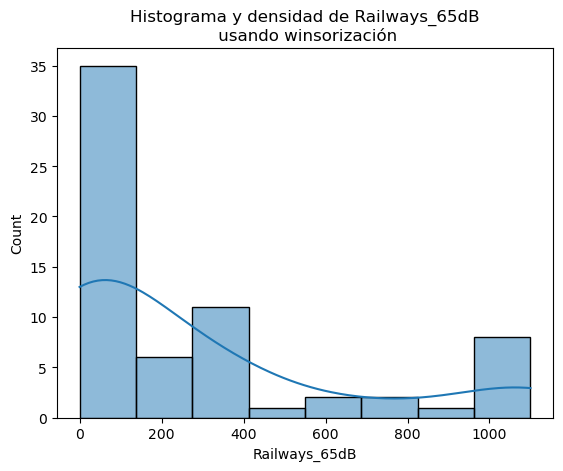

In [279]:
sns.histplot(ruidoso_winsorized['Railways_65dB'], kde=True)
plt.title("Histograma y densidad de Railways_65dB\n usando winsorización")
plt.show()

Se puede observar que el efecto de usar winsorización sobre los datos es similar a los dos métodos anteriores, la distribución resultante tiene una cola menos pesada.

# Punto 2

## Carga de datos

In [93]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

auto_mpg = fetch_ucirepo(id=9) 

# data (as pandas dataframes) 

data = pd.concat([auto_mpg.data.features, auto_mpg.data.targets], axis=1, join='outer')

## En qué consiste este dataset y sus características

Los datos contienen el consumo de combustible en millas por galón en ciudad de vehículos y sus características, las millas por galón se puede predecir en función de 3 atributos discretos multivariados y 4 atributos continuos.

1.  mpg: (millas por galón) continua
2.  cylinders: (cilindros) multi valuada discreta
3.  displacement: (desplazamiento) continua
4.  horsepower: (caballos de fuerza) continua
5.  weight: (peso) continua
6.  acceleration: (aceleración) continua
7.  model_year: (año modelo) multi valuada discreta
8.  origin: (origen) multi valuada discreta

Este dataset consiste de 398 filas y 8 columnas y puede descargarse mediante el sitio web [Auto MPG. UCI Machine Learning Repository.](https://doi.org/10.24432/C5859H).


## Análisis exploratorio para identificar la distribución de las variables usadas en la base de datos


In [94]:
dfSummary(data, is_collapsible=False)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,displacement[float64],Mean (sd) : 193.4 (104.3)min < med < max:68.0 < 148.5 < 455.0IQR (CV) : 157.8 (1.9),82 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACvElEQVR4nO3dvY7aQBRA4TthQQYiG4QEHS1FpBSUPEQeNo+QgiegpaJD/MgIsg7GOE2IImUFxoPZubPnq9deZB0ZPDPymDzPBXDdp/f+AEARL7f+wBjTFJFGyfMf8zx/LXks8NfVUI0xzV6v9y0Mw26Zk+92u60x5juxwtatO2ojDMPuZDJ5jaIouefEcRwH0+m0u16vGyJCqLBy86tfRCSKoqTf7/8scf5miWOA//AwBRUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhQb8y8qyrC4ioTGm7ClYKwARqTDUw+FQT9P063A4rNVqtbumXy9YK4CLykI9Ho8vQRC0xuNxMhgMtvcez1oB/KvSr34RkXa7XXadgAhrBfAHD1NQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlSofD2qVrxu0y2E+gZet+keQn0br9t0DKFewes23cHDFFQgVKhAqFCBUKECoUIFQoUKDE85xnJGTMTTWTFCdYjtjJiIv7NihOqW0jNiIn7PihGqgyxmxEQ8nRXjYQoqECpUIFSo4PRvVMs9ALwcprnF12vmbKi2ewD4Okxzjc/XzNlQbfYA8HmY5hqfr5mzoV5Y7AHg5TBNET5eMx6moAKhQgVChQqEChUIFSo4/9SP53F5k2VChYi4v8myt6Fa3h3C8/lcf/BHcprrmyx7Gart3SFN0yDLsi9JkvwQkbLrQlVydZNlL0O1vTssFovubDZrnU6nWhWfz1dVLojxMtSLsneH7Xbr7FSiq6peEON1qHieqhfEECoeqqoFMYRaAYvfah9utKEoQn0wm99qH3m04ZZCocZxHNx74v1+H4iIHA6HYLlctp55/Hv+781m8zkIgtZoNDKdTufXPceuVqtgPp+34jhuL5fL4z3Hiui9ZkX6+g1c4bzEC03vCgAAAABJRU5ErkJggg=="">",0(0.0%)
2,cylinders[int64],Mean (sd) : 5.5 (1.7)min < med < max:3.0 < 4.0 < 8.0IQR (CV) : 4.0 (3.2),5 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB1klEQVR4nO3dTWoCQRRF4fuCiEKoQgUX4zzTLDbTzN2NxJIQQ0A7O9DYP3TdzvnGKVKFZ2AX+DqaphFQu6exNwD8xWzsDdwSEUtJ85bLf5qmOfe5H4yn2lAjYrnZbF5TSqs260+n00dEvBHrNFQbqqR5Smm12+3OOefvRxaWUhb7/X51OBzmkgh1AmoOVZKUc/7ebrdfLZYue98MRsPDFCwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKiwQKixUP80PPoYcvEyo6MXQg5cJFX0ZdPAyoaJXQw1e5mEKFggVFggVFviOWpmOVzzSRN+vRagV6XrFI033/VqEWpfWVzzStN+vRagV6nDFI030/Vo8TMECocICocICocICocICocICocICocICocICocICocICocICocICocICocICocICocICocICocICocICocICocLC3Z9LDzmctWb/9dy1uhlq18kdx+PxMyLeJT08TEFSul6vs1LK4tGFpZTF5XKZSUoR0eJfa7Fer19yzs9tFnc4d+szS72cu4tOn9e9v/kF9gGQjnIhRucAAAAASUVORK5CYII="">",0(0.0%)
3,horsepower[float64],Mean (sd) : 104.5 (38.5)min < med < max:46.0 < 93.5 < 230.0IQR (CV) : 51.0 (2.7),93 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACoUlEQVR4nO3dP47aQBSA8TdhQQNItvgj6LjASimQaDhAyhw2R0hBkZob0CEhywhnLYxxqt1qxcKMHeZZ36+fxcUna4wfO6aqKgFC9+3ZFwDc4+XZF3CLMaYvIj3H5eeqqt7qvB48T7ChGmP6k8nkZxRFI5f1x+MxMcb8ItZ2CDZUEelFUTRar9dvcRznjyxM09RuNpvR4XDoiQihtkDIoYqISBzH+Ww2++uwtF/7xeBpeJiCCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUafYXqOf0UXa/Xbp3XA70aC9V3+qkoCluW5Wue579FxOVdP1qkyTuq8/STiMhutxttt9vB5XLpNHFx0KXx6SnX6ackSZh+wgcepqACoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKgQ/KkoGnGQW/0ItWYc5NaM1oZalmVXRCJjjOufcL2zcZBbA1oZapZl3aIovi8Wi06n03n4/16J+N/ZOMitXq0M9Xw+v1hrB8vlMp/P58mj67mzhaeVob4bDoeudzUR7mxB4espqECoUIFQoQKhQgVChQpfPvV7vA7kVBPU5maoPq8DOdUEdfrqjur8OpBTTVCnu77wd3kdyKkmqFOr30z58BhqYW/eAEL9hM9QC3vzZhDqJ3yGWtibN4NQb3AZann23rytvy4g1MB4Dnzb8Xj8I47jocvikH9dQKgB8R34LorCisjrarX6M51Oj4+sDX0Gl1AD4jvw/b4/ttYWbft1AaEGyHXgu837Y0LFh5D3x4QKEQl/f0yoEJHw98d3hZqmqX30U0+nkxURybLM7vf7wf9cr/WzQ7huXy6ffU9f/wDiyYjFeUwInwAAAABJRU5ErkJggg=="">",6(1.5%)
4,weight[int64],Mean (sd) : 2970.4 (846.8)min < med < max:1613.0 < 2803.5 < 5140.0IQR (CV) : 1384.2 (3.5),351 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACqUlEQVR4nO3dwY6aQBjA8W/qalATiDHRmy/QpAePPkQfto

### Variables continuas

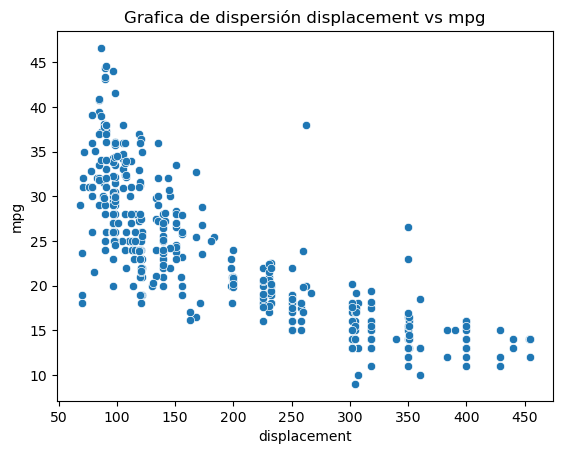

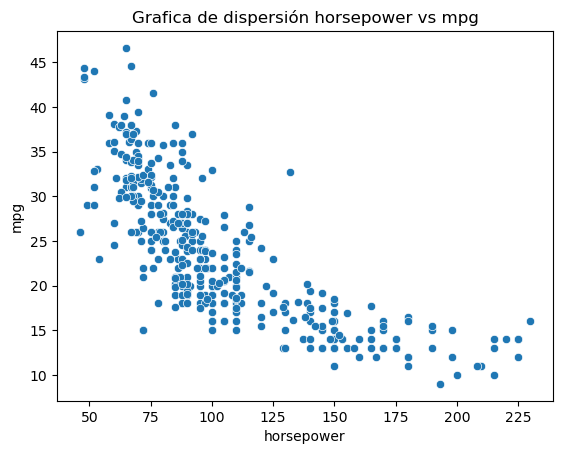

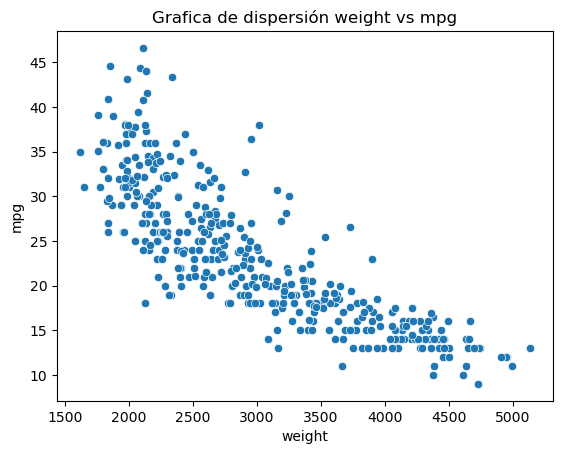

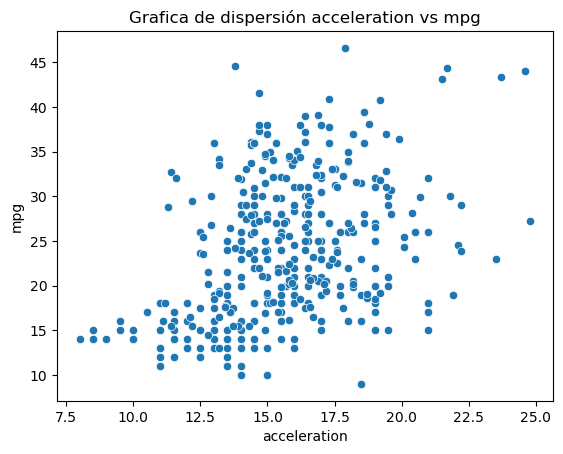

In [95]:
for col in ["displacement", "horsepower", "weight", "acceleration"]:
  # Create a scatterplot of --- vs 'acceleration'
  sns.scatterplot(x=col, y='mpg', data=data)
  
  
  plt.xlabel(f"{col}")
  plt.ylabel(f"mpg")
  plt.title(f"Grafica de dispersión {col} vs mpg")
  
  
  plt.show()

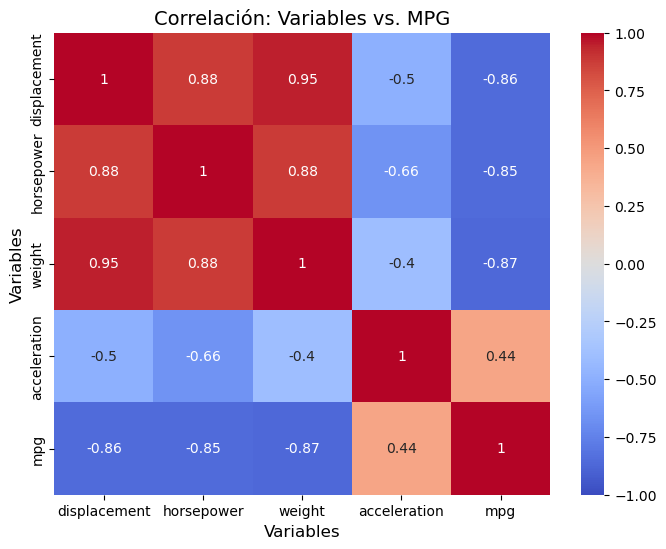

In [96]:
# List of variables to plot
X = ['displacement', 'horsepower', 'weight', 'acceleration']

# Create a correlation matrix
corr = data[X + ['mpg']].corr(method = "spearman")


# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask and annotations
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=X + ['mpg'], yticklabels=X + ['mpg'])

# Add labels
plt.title('Correlación: Variables vs. MPG', fontsize=14)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Variables', fontsize=12)

# Show the plot
plt.show()

Como podemos ver, para las variables **displacement**, **horsepower** y **weight** hay una relación inversamente proporcional con la variable mpg, mientras que para la variable **acceleration** la relación parece ser directamente proporcional.

- El **desplazamiento** del motor es el volumen barrido combinado de los pistones dentro de los cilindros de un motor. Es uno de los factores determinantes de la potencia y cuánto combustible puede consumir un vehículo. En general, cuanto **mayor** sea el **desplazamiento** del motor, **más combustible** podrá consumir y **menos rendimiento** tendrá (millas por galón).

- Típicamente, a mayor **potencia** (más caballos de fuerza, horsepower), menor eficiencia de combustible (menos millas por galón, mpg). 

- A mayor **peso** (weight) de un vehículo, menores serán sus **millas por galón** debido a que se requiere más potencia del motor y más consumo de combustible para mover un vehículo más pesado.


### Variables categoricas

In [97]:
data["origin"] = data["origin"].replace({1: "USA", 2: "Europe", 3: "Asia"})

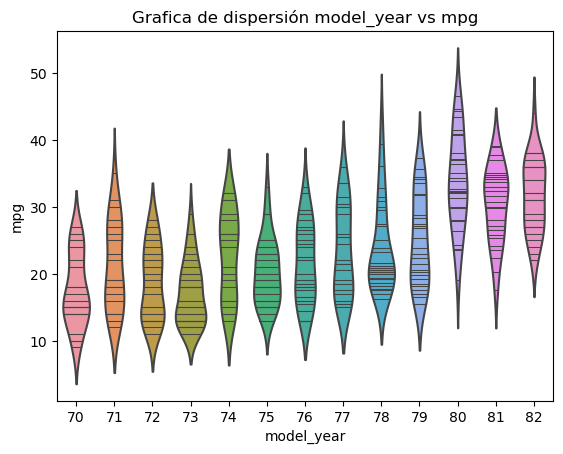

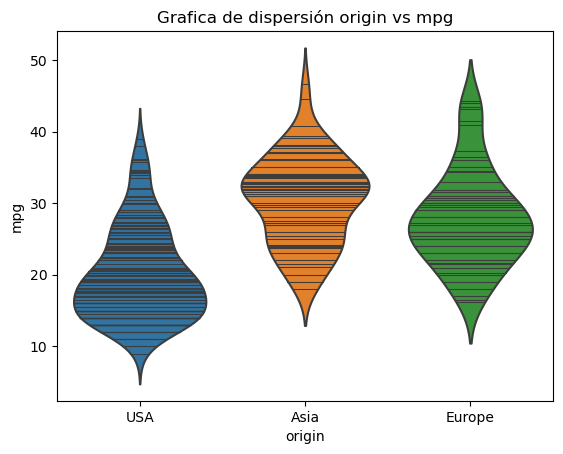

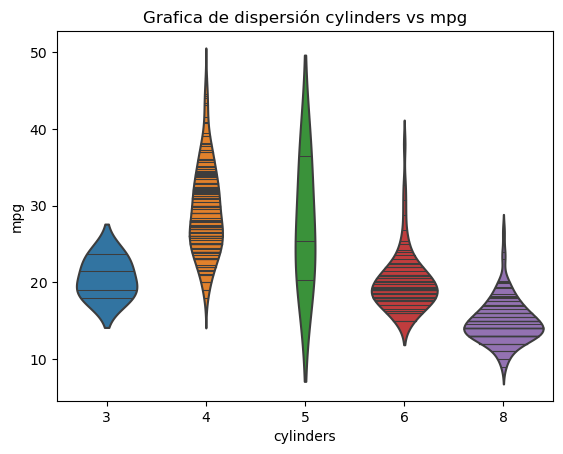

In [98]:
for col in ["model_year", "origin", "cylinders"]:
  
  sns.violinplot(x=col, y='mpg', bw_adjust=.5, inner="stick", data=data)
  # Add labels and title
  plt.xlabel(f"{col}")
  plt.ylabel(f"mpg")
  plt.title(f"Grafica de dispersión {col} vs mpg")
  
  # Display the plot
  plt.show()

Para la variable **año de modelo**

Se ve que entre más aumenta el año del modelo el rendimiento del combustible en millas es mayor, lo que se puede dar por mejoras en tecnología.

Para la variable **origen**

Se puede observar que el origen con mejor millas por galón es Asia mientras que el peor es USA.

Para la variable **cilindros**

Se observa que para 4 cilindros el rendimiento es alto, mientras que para 8 es bajo, esto puede ser por la relación proporcional que existe el numero de cilindros y la potencia, lo que puede afectar el rendimiento de la gasolina.


## Datos faltantes en cada uno de las variables.



En la siguiente tabla se encuentran los porcentajes de NAs para cada columna, podemos ver que la única columna con NAs es **horsepower** con 1.5% de NAs


In [99]:
from itables import show
tbl = data.isna().sum()/data.shape[0]*100
show(tbl, caption="% de NAs para cada columna")

## ¿Cuál cree que es el mecanismo inherente a esos datos faltantes?

Puede ser que la columna **horsepower** contiene datos faltantes porque se olvidaron registrarlo o no tenían la información disponible.

## Técnicas de tratamiento de datos faltantes (vistas en clase)

### Imputar datos faltantes en la columna horsepower 

Como vimos, esta columna es continua, por lo que vamos a realizar dos impútaciones, una usando una regresión y la otra 

#### Usando Regresión Lineal

Si nos devolvemos al análisis descriptivo podemos observar que la variable horsepower tiene correlación con las demás variables continuas, por lo que usare todas estas para hacer la regresión


In [100]:
es_na = data["horsepower"].isna()
X = data[~es_na][['displacement', 'mpg', 'weight', 'acceleration']].copy()
y = data[~es_na]["horsepower"].copy()

In [101]:
from sklearn.linear_model import LinearRegression
from fancyimpute  import IterativeImputer
import miceforest as mf

reg = LinearRegression().fit(X, y)

In [102]:
reg.score(X, y)

0.8886520648717191

Como podemos ver este modelo lineal tiene un $R^2$ del $0.89$, el cual es bueno considerando que es una RLS y los patrones de los datos parecían tener una relación no lineal, lo cual significa que en el caso de que sea muy necesario tener una alta precisión en la predicción se puede tratar de mejorar esta imputación aún más. 

In [103]:
X_pred = data[es_na][['displacement', 'mpg', 'weight', 'acceleration']].copy()

Valores predichos para las filas con valores faltantes de horsepower:


In [104]:
valores_horsepower = reg.predict(X_pred)
print(valores_horsepower)

[ 60.92717401  97.29052151  57.42697868 103.419523    77.34333127
  77.84146627]


In [105]:
data["horsepower_imp_con_rl"] = data["horsepower"].values
data.loc[es_na, "horsepower_imp_con_rl"] = valores_horsepower


#### Usando IterativeImputer

Este imputador multivariado estima cada valor faltante a partir de todas las demás.

Esta es una estrategia para imputar valores faltantes modelando cada característica con valores faltantes como una función de otras características de forma cíclica.

Para [esta librería](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) podemos ver que tiene muchos más parámetros, en este caso usamos "imputation_order='ascending'" para indicar que el orden en que se va a realizar la imputación es empezando con columnas con menos valores faltantes a más, como es solo una columna esta columna no hace ninguna diferencia.


In [106]:
# Crear una copia de las variables excluyendo la creada anteriormente e incluir solo columnas numericas
data_para_hotdeck = data[['displacement', 'mpg', 'weight', 'acceleration', 'horsepower']].copy()

# Imputar valores faltantes utilizando el método de Hot-Deck
imputer = IterativeImputer(imputation_order='ascending')
data_imputed = imputer.fit_transform(data_para_hotdeck)

# Agregar columna a data
data["horsepower_imp_con_hotdeck"] = data_imputed[:, -1]

#### Usando miceforest

La Imputación Múltiple mediante Ecuaciones Encadenadas 'rellena' (imputa) los datos faltantes en un conjunto de datos a través de una serie iterativa de modelos predictivos. En cada iteración, cada variable especificada en el conjunto de datos se imputa utilizando las otras variables del conjunto de datos. Estas iteraciones deben ejecutarse hasta que parezca que se ha alcanzado la convergencia.

Con [este paquete](https://github.com/AnotherSamWilson/miceforest) usamos la metodología MICE, como se puede leer en su github, este usa el modelo **lightgbm**, el cual es un modelo basado en arboles de decisión.

In [107]:
kds = mf.ImputationKernel(
  data[['displacement', 'mpg', 'weight', 'acceleration', 'horsepower']].copy(),
  save_all_iterations=True,
  random_state=123
)

# Correr el algoritmo MICE en 3 iteraciones
kds.mice(3)

# Retornar el dataset
data_mf = kds.complete_data()

In [108]:
data["horsepower_imp_con_mf"] = data_mf["horsepower"]

#### Otros modelos

Se usaron los modelos anteriores porque los valores faltantes son númericos, existen otros modelos que se pueden usar en casos donde los datos faltantes hacen parte de columnas de tipo categórico, por ejemplo el imputaciones usando el modelo KNN.



## Variación en la distribución de los datos al aplicar las técnicas de imputación de datos

En cada método se guardo la columna horsepower imputada.

Como observamos, el porcentaje de datos es de solo el 1.5%, por lo que si comparamos las tres tecnicas no se va a observar mayor diferencia.


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

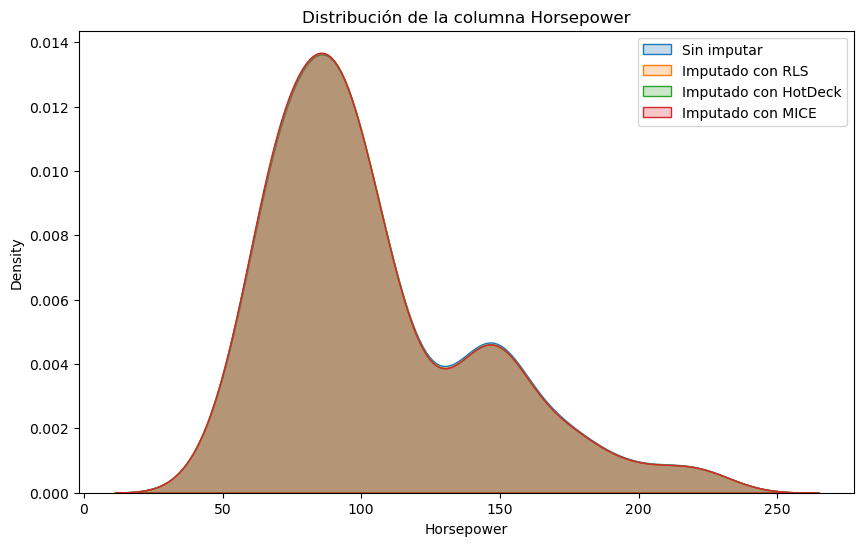

In [109]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(data=data, x='horsepower', fill=True, label='Sin imputar', ax=ax)
sns.kdeplot(data=data, x='horsepower_imp_con_rl', fill=True, label='Imputado con RLS', ax=ax)
sns.kdeplot(data=data, x='horsepower_imp_con_hotdeck', fill=True, label='Imputado con HotDeck', ax=ax)
sns.kdeplot(data=data, x='horsepower_imp_con_mf', fill=True, label='Imputado con MICE', ax=ax)

ax.set_xlabel('Horsepower')
ax.set_ylabel('Density')
ax.set_title('Distribución de la columna Horsepower')

ax.legend()

plt.show()

<Figure size 1000x600 with 0 Axes>

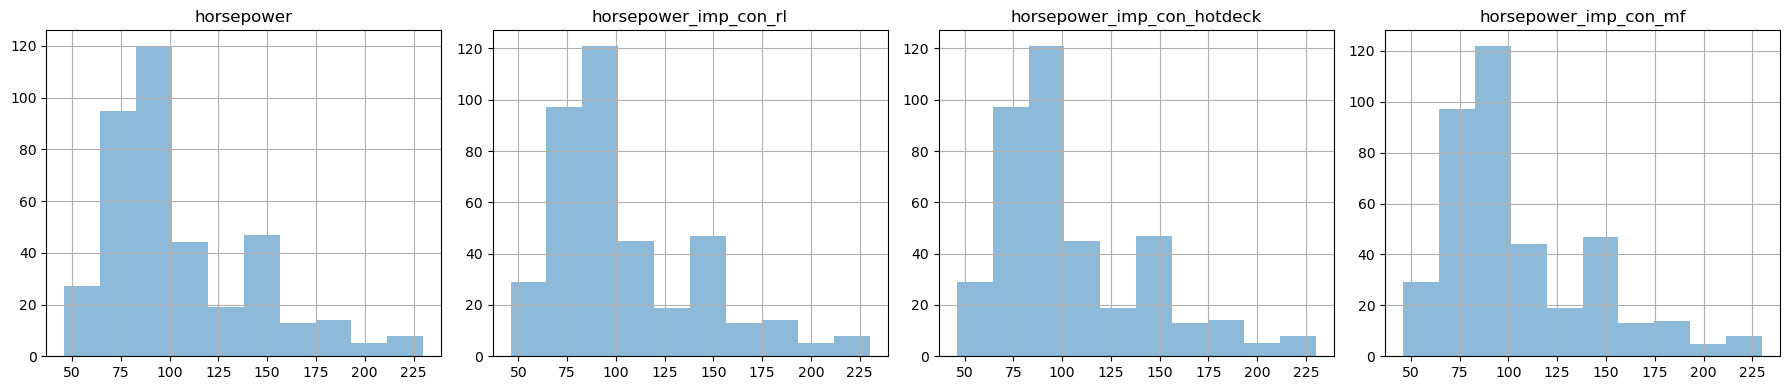

In [110]:

plt.figure(figsize=(10, 6))
data.hist(column=['horsepower', 'horsepower_imp_con_rl', 'horsepower_imp_con_hotdeck', 'horsepower_imp_con_mf'], alpha=0.5, layout=(1, 4), figsize=(18, 4))
plt.tight_layout()
plt.show()


Se puede observar que la densidad de los datos es muy parecida, esto se da ya que el % de NAs es una fracción pequeña de los datos.

In [111]:
data[['horsepower', 'horsepower_imp_con_rl', 'horsepower_imp_con_hotdeck', 'horsepower_imp_con_mf']].describe()

,horsepower,horsepower_imp_con_rl,horsepower_imp_con_hotdeck,horsepower_imp_con_mf
count,392.000000,398.000000,398.000000,398.000000
mean,104.469388,104.086053,104.086918,104.050251
std,38.491160,38.381670,38.380639,38.389263
min,46.000000,46.000000,46.000000,46.000000
25%,75.000000,75.000000,75.000000,75.000000
50%,93.500000,92.500000,92.500000,92.000000
75%,126.000000,125.000000,125.000000,125.000000
max,230.000000,230.000000,230.000000,230.000000


También podemos observar que la media y mediana se desplazan levemente hacia abajo en todas las imputaciones, mientras que el máximo y mínimo se mantiene constante.

Se observa que existe una leve disminución en la variación de los datos imputados. 